# SRCNN을 이용해 Super Resolution 도전하기

이번에는 앞서 간략하게 알아보았던 SRCNN을 구현하고 실험해봅시.

다운로드한 데이터셋이 준비되어 있어야 합니다.



tensorflow-datasets 라이브러리에서 우리가 사용해 볼 데이터셋은 DIV2K입니다. 

DIV2K 데이터셋은 많은 Super Resolution 연구에서 학습 및 평가에 사용되는 데이터셋이며 800개의 학습용 데이터셋
및 100개의 검증용 데이터셋으로 구성되어 있습니다.


<br>


앞서 다운로드 한 데이터셋은 div2k/bicubic_x4이며, 이는 DIV2K 데이터셋 중에서 실제 고해상도 이미지를 대상으로 bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4배로 줄인 데이터셋 입니다. 

이렇게 만들어진 저해상도 이미지와 원래 고해상도 이미지가 서로 한 쌍으로 구성되어 있습니다.


https://data.vision.ee.ethz.ch/cvl/DIV2K/

아래에서 진행하는 SRCNN의 구현 및 학습 과정은 매우 간단한 과정만을 거치며, 실제 SRCNN 논문에서 진행한 방식과 세부적으로 차이가 있습니다. 

이에 대한 자세한 내용은 SRCNN의
논문을 참고 바랍니다.

### 데이터 준비하기

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteD9L9RC/div2k-train.tfrecord*...:   0%|       …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteD9L9RC/div2k-validation.tfrecord*...:   0%|  …

Dataset div2k downloaded and prepared to ~/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


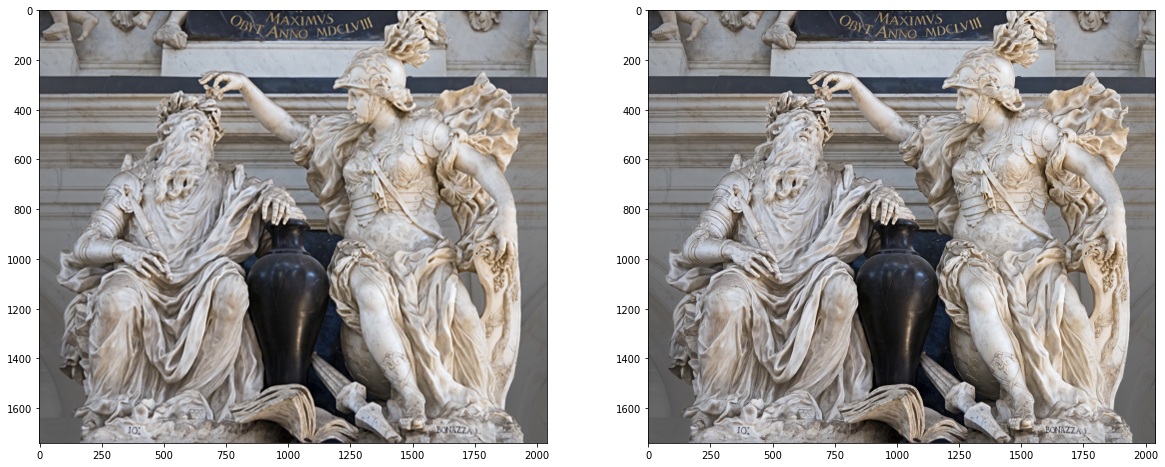

In [2]:
"""
생성한 train과 valid는 각각 저해상도 및 고해상도 이미지를 쌍으로 담고 있습니다.
그중 한 쌍의 이미지에 대해 시각화해봅시다
저해상도 이미지를 bicubic interpolation하여 고해상도 이미지와 동일한 크기로 만들었습니다.
"""

# 데이터를 불러옵니다.
train, valid = tfds.load(
"div2k/bicubic_x4",
split=["train","validation"],
as_supervised=True
)
# 시각화를 위해 한 개의 데이터만 선택합니다.
for i, (lr, hr) in enumerate(valid):
    if i == 6: break
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
lr,
dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
interpolation=cv2.INTER_CUBIC # bicubic 설정
)
# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)

이미지 크기가 꽤 크기 때문에 어렴풋이 봐서는 선명함의 차이가 크지 않은 것 같습니다. 

아래 코드를 이용해 각 이미지의 특정 부분을 확대해봅시다.

Text(0.5, 1.0, 'HR')

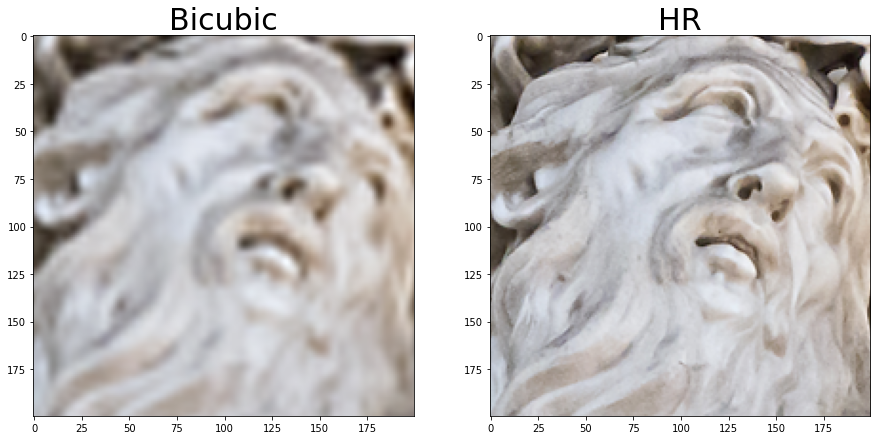

In [3]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]
# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.

left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_hr = crop(hr, left_top)
# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

Bicubic interpolation 방법을 이용한 결과는 HR이라 쓰여진 실제 고해상도 이미지와 비교하면 매우 선명하지 않은 것을 확인 할 수 있습니다. 

SRCNN을 이용해 학습한 결과는 얼마나 좋을지 아래에서 확인해 봅시다


앞서 언급되었듯이 SRCNN의 입력은 저해상도 이미지를 그대로 사용하는 것이 아닌, 만들고자 하는 고해상도 이미지 크기에 맞게 interpolation이 적용된 이미지입니다. 

이 과정을 아래 코드와 같이 수행합니다. 

사용할 DIV2K 데이터셋 내의 개별 이미지 크기가 크므로, 일부 영역을 임의로 잘라내어 학습에 활용해 보겠습니다.

In [4]:
import tensorflow as tf
def preprocessing(lr, hr):
# 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3])
    hr = tf.cast(hr, tf.float32) / 255.
# 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
# interpolation을 이용해 다시 원래 크기로 되돌립니다.
# 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic")
    lr = tf.image.resize(lr, [96, 96], "bicubic")
    return lr, hr
train = train.map(preprocessing).shuffle(buffer_size=10).batch(16)
valid = valid.map(preprocessing).batch(16)
print("✅")

✅


### SRCNN 구현하기

앞서 살펴본 대로 SRCNN은 3개 convolutional layer를 사용한 구조를 가지고 있습니다.

따라서 아래 코드와 같이 Sequential API를 활용해 간단하게 구현할 수 있습니다.

In [5]:
from tensorflow.keras import layers, Sequential
# 3개의 convolutional layer를 갖는 Sequential 모델을 구성합니다.
srcnn = Sequential()
# 9x9 크기의 필터를 128개 사용합니다.
srcnn.add(layers.Conv2D(128, 9, padding="same", input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(64, 5, padding="same"))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(3, 5, padding="same"))
srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   31232     
                                                                 
 re_lu (ReLU)                (None, None, None, 128)   0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    204864    
                                                                 
 re_lu_1 (ReLU)              (None, None, None, 64)    0         
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     4803      
                                                                 
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


### SRCNN 학습하기

최적화 방법과 손실 함수를 설정하고, 앞서 전처리한 데이터를 이용해 아래와 같이 간단하게 학습할 수 있습니다. 

우선 1 epoch만 학습 시켜 봅시다.

In [6]:
srcnn.compile(
optimizer="adam",
loss="mse"
)
srcnn.fit(train, validation_data=valid, epochs=1)

50/50 [==============================] - 438s 8s/step - loss: 0.0190 - val_loss: 0.0061


### SRCNN 테스트하기

SRCNN의 학습에는 꽤나 오랜시간이 소요되어 여기서 SRCNN을 처음부터 끝까지 학습시키지 않겠습니다. 

대신 SRCNN을 사용해보기 위해 이미 학습이 완료된 SRCNN 모델을 준비했습니다.


아래 srcnn.h5 파일을 다운로드받은 후 코드를 실행하여 학습 완료된 모델을 불러올 수 있습니다.

In [7]:
import tensorflow as tf
import os
model_file ='/content/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

아래 코드와 같이 저해상도 이미지를 입력받아 SRCNN을 사용하는 함수를 간단하게 정의합니다. 

이 함수를 이용해 SRCNN의 결과인 고해상도 이미지를 얻어봅시다.

In [8]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))
srcnn_hr = apply_srcnn(bicubic_hr)

이전 bicubic interpolation을 적용하고 이미지 전체를 시각화했을 때 세부적인 선명함이 눈에 띄지 않았기 때문에, 일부 영역을 잘라내어 시각적으로 비교해보겠습니다.

아래 코드를 이용해 3개 이미지 (bicubic interpolation의 결과, SRCNN의 결과, 원래 고해상도 이미지)를 나란히 시각화합니다.

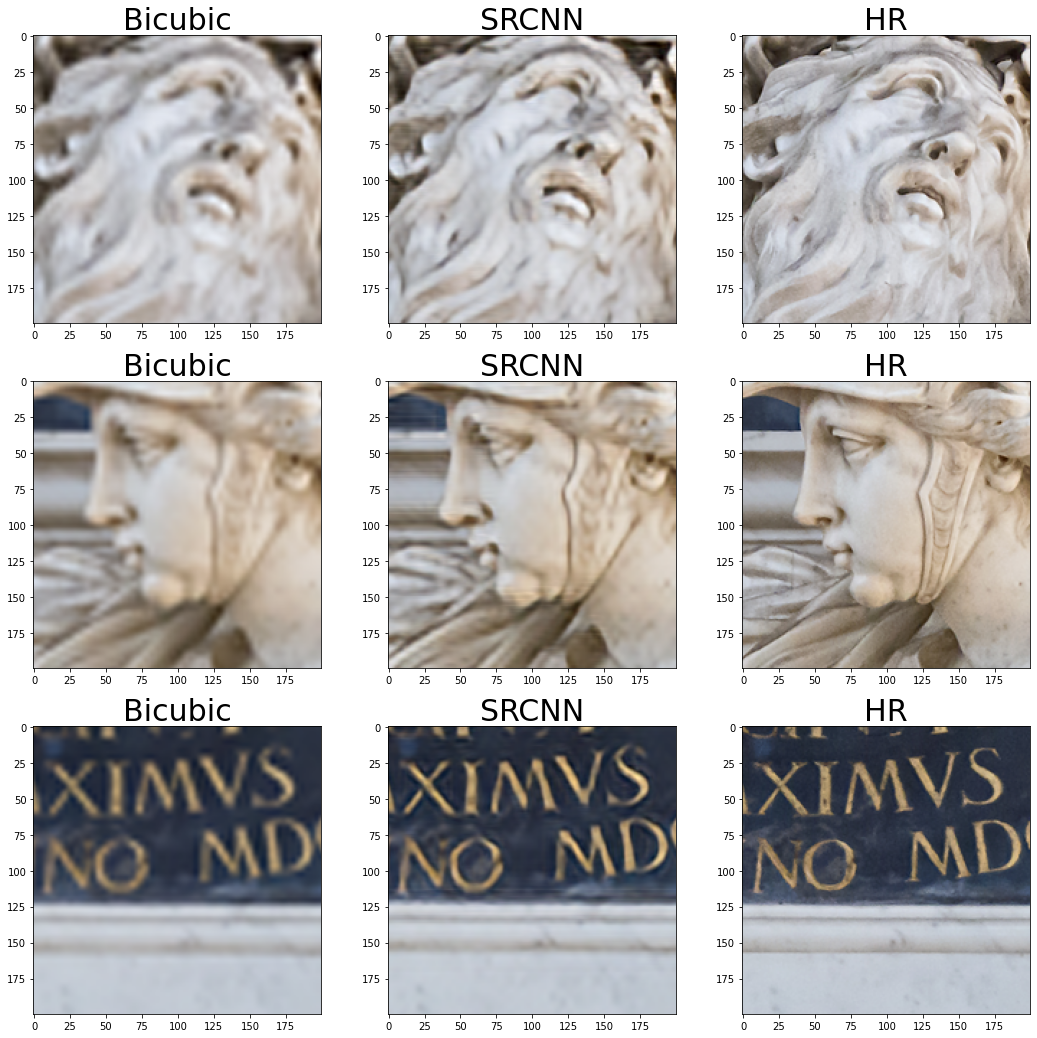

In [9]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]
images = []

for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srcnn_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

시각화 결과 bicubic interpolation 결과보다 조금 더 선명해졌지만 원래 고해상도 이미지에 비해 만족할만한 성능은 아닌 것 같습니다. 

DIV2K 데이터셋이 비교적 세밀한 구조의 이미지가 많아 SRCNN과 같이 간단한 구조로는 더 이상 학습되지 않는 것으로 보입니다.

실제로 SRCNN 논문에서는 아래와 같이 비교적 간단한 구조의 이미지에 대해서는 꽤나 만족할 만한 성능을 보여줍니다.

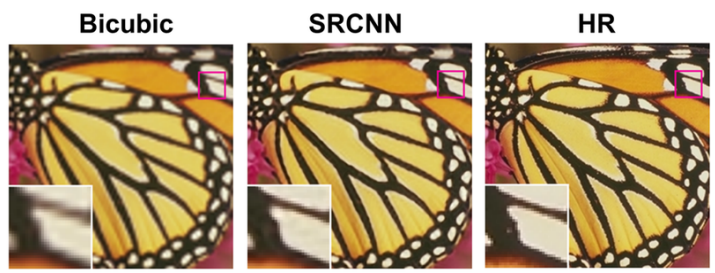

## Deep Learning을 이용한 Super Resolution: SRGAN

이번에는 GAN을 활용한 Super Resolution 과정에 대해 다뤄보려 합니다. 

고해상도 이미지를 만들어 내는데 GAN이 어떻게 활용될 수 있고, 이를 활용했을 때 어떠한 장점이 있는지 학습을 통해 알아봅시다.

<br>


다시 한번, GAN

이번 학습을 시작하기 전에 GAN을 대략적으로 알고 있다고 전제 했지만, GAN에 대해 다시 한번 가볍게 정리해 보겠습니다. 

아래 참고 자료를 읽고 질문에 답해봅시다.

https://www.samsungsds.com/global/ko/support/insights/Generative-adversarial-network-AI.html?moreCnt=19&backTypeId=undefined&category=undefined

위 자료에서는 데이터의 확률분포를 모델링 할 수 있다면, 무엇이 가능하다고 했나요?

>원래 데이터와 확률분포를 정확히 공유하는 무한히 많은
새로운 데이터를 생성할 수 있다.

<br>

GAN의 학습이 완료되었을 때, Generator(생성자)와
Discriminator(판별자)의 출력은 무엇인가요?

>Generator의 경우 원 데이터의 확률분포를 따르는 새로운
데이터를 만들며, Discriminator의 경우 분류에 의미가 없는
0.5의 확률값을 출력한다

https://www.samsungsds.com/global/ko/support/insights/Generative-adversarial-network-AI-2.html


비지도학습의 의미와 일맥상통하는 물리학자 Richard Feynman의 명언을 적어주세요.

>What I cannot create, I do not understand

<br>

GAN을 경찰과 위조지폐범으로 비유했을 때, 각각은 GAN
내에서 어떤 모델에 해당하는지, 각각의 목표는 무엇인지
설명해주세요.

>위조지폐범은 Generator(생성자, 생성모델)에 해당하며,
위조지폐를 잘 만들어 경찰을 속이고자 한다. 경찰은
Discriminator(판별자, 판별모델, 분류모델)에 해당하며,
진짜 지폐와 위조지폐를 정확히 구분하여 위조지폐범을
검거하고자 한다.

### 데이터 준비하기

In [10]:
train, valid = tfds.load(
"div2k/bicubic_x4",
split=["train","validation"],
as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
# 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.  
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
# 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
# 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.

    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch
train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)
print("✅")

✅


### SRGAN 구현하기

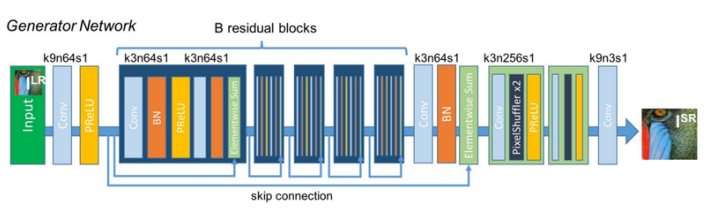

그림 내의 라는 표기는 Convolutional layer 내의 hyperparameter 설정에 대한 정보이며,
k는 kernel size, n은 사용 필터의 수, s는 stride를 나타냅니다. 

Tensorflow로 구현한다면 Conv2D(filters=64, kernel_size=9, strides=1, padding="same") 처럼 작성할 수 있습니다. 

추가로 모든 stride가 1인 convolutional layer에는 패딩을 통해 출력의 크기를 계속 유지합니다.

SRGAN의 Generator에는 skip-connection을 가지고 있으며, 이는 Sequential API로 구현할 수 없으므로 Functional API를 이용해 아래와 같이 구현해 보겠습니다. 

위 Generator 그림에서 각
layer를 따라 비교하면서 아래 코드를 이해해 봅시다.

In [11]:
from tensorflow.keras import Input, Model, layers
# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])
# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
# 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)   
    for _ in range(5):
        out = gene_base_block(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])

    for _ in range(2):
        out = upsample_block(out)
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)
print("✅")

✅


이번에는 생성된 고해상도 이미지와 진짜 고해상도 이미지 사이에서 진짜를 판별해내는 Discriminator를 아래 그림에 따라 구현해 보겠습니다. 

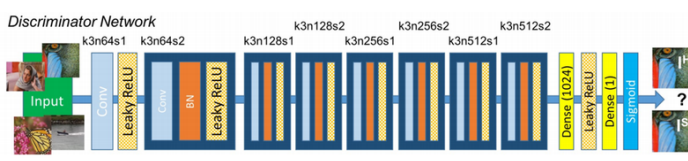

마찬가지로 Functional API를 사용합니다.

In [12]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)
# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)
print("✅")

✅


SRGAN은 VGG19를 이용해 content loss를 계산합니다. 

Tensorflow는 이미지넷 데이터로부터 잘 학습된 VGG19를 제공하고 있으며 이를 이용해 보겠습니다.

In [24]:
from tensorflow.keras.applications import vgg19
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = tf.keras.applications.vgg19.VGG19(
include_top=False,
weights="imagenet",
input_shape=input_shape
)
# 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)
print("✅")

✅


### SRGAN 학습하기

이제부터는 앞에서 정의한 신경망들을 이용해 SRGAN을 학습해 보겠습니다. 

이전에 SRCNN과 마찬가지로 학습에 꽤나 오랜 시간이 소요되므로 SRGAN의 학습을 처음부터 전부 진행하진
않겠습니다. 

여기서는 200번의 반복만 진행해보겠습니다.
(초반 학습이 불안정하여 Generator의 loss가 증가할 수도 있습니다)

In [ ]:
import tensorflow as tf
from tensorflow.keras import losses, metrics, optimizers
generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)
def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)

@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = tf.keras.applications.vgg19.preprocess_input(hr_real)  
    hr_fake = tf.keras.applications.vgg19.preprocess_input(hr_fake)

    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)

        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
# 10회 반복마다 loss를 출력합니다.

        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f}")

        if (i+1) == 200:
            break
    gene_losses.reset_states()
    disc_losses.reset_states()  

### SRGAN 테스트하기


SRGAN이 만족스러운 결과를 도출할 때까지는 상당히 많은 학습 시간을 요구합니다. 이전과 마찬가지로 이미 학습이 완료된 SRGAN을 미리 준비해 놓았습니다

이를 이용해 테스트해 봅시다.

SRGAN은 크게 두 개의 신경망(Generator, Discriminator)으로 구성되어 있지만, 테스트에는 저해상도 입력을 넣어 고해상도 이미지를 출력하는 Generator만 이용합니다. 

아래 srgan_G.h5 파일은 학습이 완료된 Generator이며, 이를 다운로드받아 코드를 실행해 학습 완료된 모델을 불러옵니다.

In [26]:
import tensorflow as tf
import os
model_file ='/content/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

아래 코드와 같이 테스트 과정을 진행하는 함수를 간단하게 정의하고, 이 함수를 이용해 이전에 사용했던 이미지에 대해 SRGAN의 고해상도 결과를 생성합니다.

In [27]:
import numpy as np
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
"div2k/bicubic_x4",
split=["train","validation"],
as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr)
print("✅")

✅


이미지 전체를 시각화했을 때 세부적인 선명함이 눈에 띄지 않았기 때문에, 일부 영역을 잘라내어 시각적으로 비교해보겠습니다

아래 코드를 이용해 3개 이미지(bicubic interpolation의 결과,
SRGAN의 결과, 원래 고해상도 이미지)를 나란히 시각화합니다.

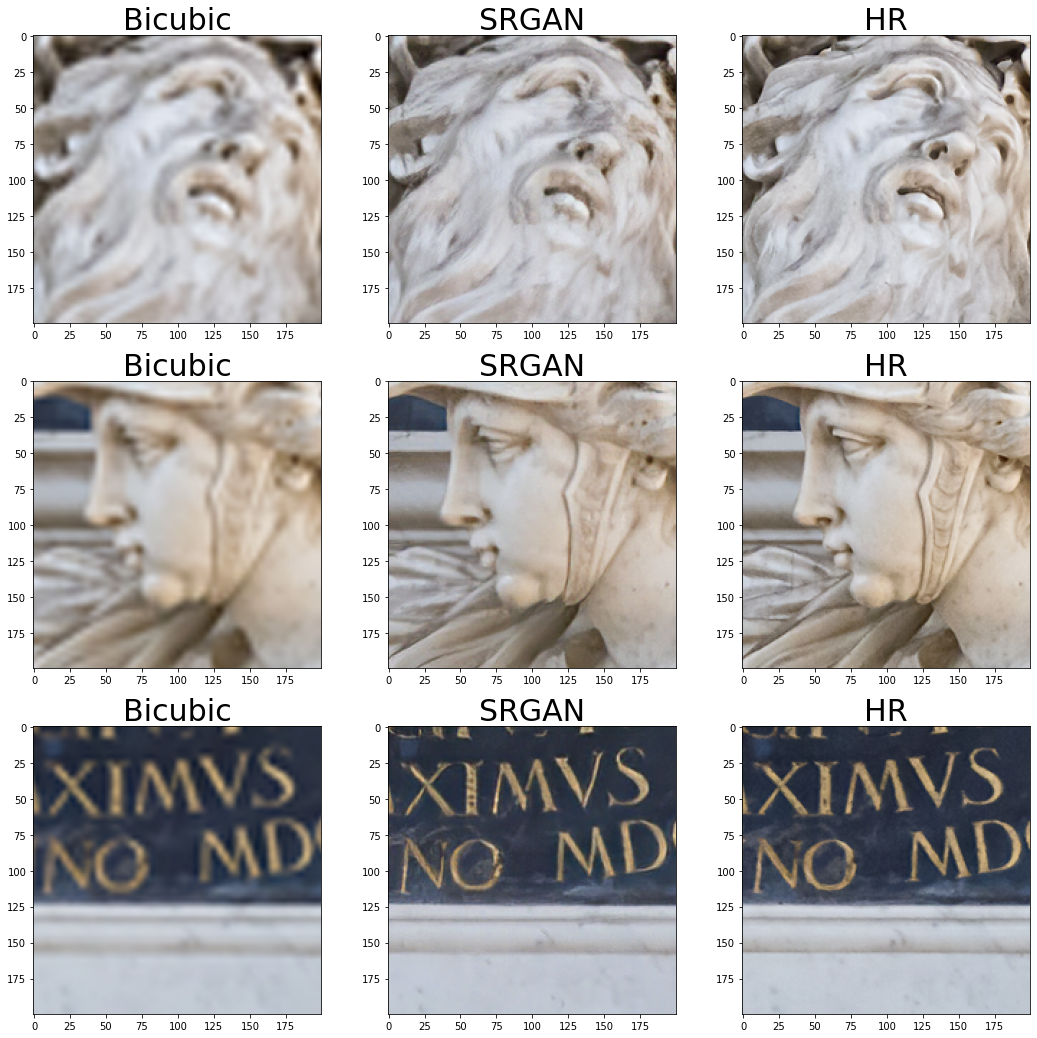

In [28]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]
images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):

    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

시각화 결과 bicubic interpolation보다 훨씬 더 원래 고해상도 이미지에 가까운, 꽤나 만족할만한
결과를 얻은 것 같습니다! 


이전에 사용했던 SRCNN 보다 더 깊은 신경망 구조를 사용했고, GAN 및 VGG 구조를 이용한 손실 함수를 사용해 복잡하게 학습 과정을 구성한 보람이 있네요

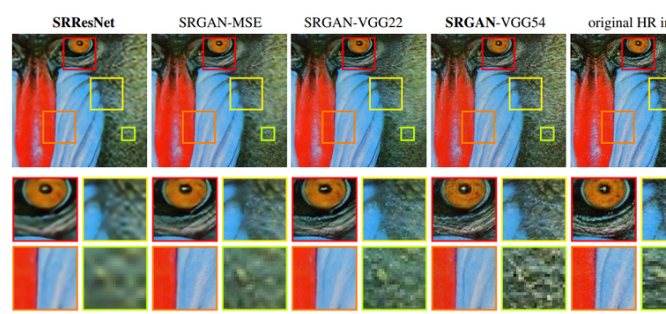

위 그림은 SRGAN 논문에서 세부적으로 실험한 결과를 나타냅니다.

가장 첫 번째 SRResNet은 SRGAN의 Generator를 뜻하며, Generator 구조만 이용해 SRCNN과 비슷하게 MSE 손실함수로
학습한 결과입니다. 

오른쪽으로 갈수록 GAN 및 VGG 구조를 이용하여 점점 더 이미지 내 세부적인 구조가 선명해짐을 알 수 있습니다. (VGG22는 VGG54에 비해 더 low-level의 특징에서 손실을
계산했습니다)